# 1 Node2vec
For the **biased random walk**, implementation from [StellarGraph](https://stellargraph.readthedocs.io/en/stable/)  
For Word2Vec implementation from [Gensim](https://radimrehurek.com/gensim/models/word2vec.html)

In [1]:
# Packages
import numpy as np
import pandas as pd
from zipfile import ZipFile
import networkx as nx
from fastprogress import master_bar, progress_bar

from sklearn.manifold import TSNE
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

import multiprocessing
from collections import defaultdict
import random as rd
rd.seed(1)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from gensim.models import Word2Vec

StellarGraph

In [4]:
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git

  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-y4i0bwcc
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-y4i0bwcc
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py) ... done
  Created wheel for stellargraph: filename=stellargraph-1.3.0b0-py3-none-any.whl size=431845 sha256=940bb24c39db10ea5b0d09d462c6ace87980c55a9bada49a487e677d064aaef0
  Stored in directory: /tmp/pip-ephem-wheel-cache-r4vvsrqc/wheels/f3/06/0f/089f69af27d308a1830638f855b6c5755311d8ffc451de9980
Successfully built stellargraph


In [5]:
import sys
if 'google.colab' in sys.modules:
  !pip install -q stellargraph[demos]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00


In [6]:
from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.data import BiasedRandomWalk

In [8]:
df_anime = pd.read_csv("anime.csv")
df_rating = pd.read_csv("rating.csv")

Mount google drive

## 1.2 Parameters

In [9]:
# maximum length of a random walk
walk_length = 10

# k = nodes sample out of the total amount
# to stay consinstent with GNN implementation
k = 15000

train_size = 0.7
val_size = 0.25
test_size = 0.3

seed = 11

## 1.1 Load data

### 1.1.1 Load DataFrames

In [10]:
df_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [11]:
df_rating

,user_id,anime_id,rating
0,1,20.0,-1.0
1,1,24.0,-1.0
2,1,79.0,-1.0
3,1,226.0,-1.0
4,1,241.0,-1.0
...,...,...,...
950485,8655,1453.0,10.0
950486,8655,1525.0,10.0
950487,8655,1526.0,7.0
950488,8655,1527.0,10.0


Elimination of rows that have Nan values

In [12]:
#df_anime.dropna(inplace=True)
df_rating.dropna(inplace=True)

In [13]:
df_rating

,user_id,anime_id,rating
0,1,20.0,-1.0
1,1,24.0,-1.0
2,1,79.0,-1.0
3,1,226.0,-1.0
4,1,241.0,-1.0
...,...,...,...
950484,8655,1311.0,7.0
950485,8655,1453.0,10.0
950486,8655,1525.0,10.0
950487,8655,1526.0,7.0


Elimination of all rating values whose anime doesn't have a description in file 'anime.csv'

In [14]:
for i in df_rating.anime_id.unique():
  if df_anime[df_anime['anime_id'] == i].empty:
    df_rating = df_rating[df_rating['anime_id'] != i]

Elimination of all user-item interactions when a rate has not been given (rating = -1)

In [15]:
# number of user that have seen an anime, but didn't give a rate (meaning rating = -1)
df_rating[df_rating['rating'] == -1].rating.value_counts()

rating
-1.0    173616
Name: count, dtype: int64

In [17]:
# Count the number of rows with rating = -1
num_rows_with_minus_one = df_rating[df_rating['rating'] == -1].shape[0]

# Print the count for verification
print(f"Number of rows with rating -1: {num_rows_with_minus_one}")

# Create a new dataframe without user-item interactions with rating = -1
new_df_rating = df_rating[df_rating['rating'] != -1]

# Update the assertion to use the counted number of rows with rating -1
assert new_df_rating.shape[0] == df_rating.shape[0] - num_rows_with_minus_one

# Update df_rating with the new dataframe
df_rating = new_df_rating

# Delete the temporary dataframe to free up memory
del new_df_rating

Number of rows with rating -1: 173616


Number of possible nodes and edges after the pre-processing phase

In [18]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items

print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  16073
Number of edges:  776873


### 1.1.2 Load graph

In [20]:
G = nx.readwrite.edgelist.read_weighted_edgelist('graph.edgelist')

In [21]:
# Add user node type
for i in df_rating.user_id.unique():
  attrs = {'user_' + str(i): {'node_type':'user'}}
  nx.set_node_attributes(G, attrs)

# Add anime node type
for i in df_rating.anime_id.unique():
  attrs = {'anime_' + str(i): {'node_type':'anime'}}
  nx.set_node_attributes(G, attrs)

Stellar Graph

In [24]:
rd.seed(seed)
k_nodes = rd.sample(list(G.nodes()), k=k)
subG = G.subgraph(k_nodes)

userList = [n for n, d in subG.nodes(data=True) if d.get('node_type') == 'user']
animeList = [n for n, d in subG.nodes(data=True) if d.get('node_type') == 'anime']

num_users = len(set(userList))
num_items = len(set(animeList))

print('Number of users: ', num_users)
print('Number of animes: ', num_items)
print()
print('[Info] Number of NODES: ', num_users + num_items)
print('[Info] Number of EDGES: ', len(subG.edges()))

Number of users:  4888
Number of animes:  0

[Info] Number of NODES:  4888
[Info] Number of EDGES:  517271


In [25]:
data_user = defaultdict()
data_anime = defaultdict()


# --------- Users features ------------
# -------------------------------------
for i in userList:
  avg_rating = np.mean([e[2]['weight'] for e in G.edges(i, data=True)])
  data_user[i] = avg_rating

user_features = pd.DataFrame.from_dict(data_user, orient='index', columns=['avg_rating'])


# --------- Anime features ------------
# -------------------------------------
for i in animeList:
  # RATING
  code = int(i[6:])
  rating = df_anime[df_anime['anime_id']==code].rating.to_string(index=False)
  if rating != 'NaN':
    rating = float(rating[1:])
  else:
    rating = 0.0

  # MEMBERS
  members = int(df_anime[df_anime['anime_id']==code].members.to_string(index=False)[1:])

  # FEATURES
  data_anime[i] = [rating, members]


anime_features = pd.DataFrame.from_dict(data_anime, orient='index', columns=['rating', 'members'])

In [27]:
g = StellarGraph.from_networkx(subG, node_type_attr='node_type', edge_weight_attr='weight', edge_type_default='rating',
                               node_features={'user': user_features, 'anime': anime_features})
print(g.info())

StellarGraph: Undirected multigraph
 Nodes: 15000, Edges: 517271

 Node types:
  default: [10112]
    Features: none
    Edge types: default-rating->default, default-rating->user
  user: [4888]
    Features: float32 vector, length 1
    Edge types: user-rating->default

 Edge types:
    default-rating->user: [280891]
        Weights: range=[1, 10], mean=7.75494, std=1.58645
        Features: none
    default-rating->default: [236380]
        Weights: range=[1, 10], mean=7.81056, std=1.58633
        Features: none


## 1.3 Embeddings generator


### 1.3.1 node embeddings

In [28]:
# Biased random walks
rw = BiasedRandomWalk(g)

weighted_walks = rw.run(
    nodes=g.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=seed,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 150000


In [31]:
weighted_model = Word2Vec(
    sentences=weighted_walks, vector_size=128, window=5, min_count=0, sg=1, workers=1, epochs=1
)

### 1.3.2 edge embeddings

In [33]:
node_ids = weighted_model.wv.index_to_key  # list of node IDs
weighted_node_embeddings = weighted_model.wv.vectors

In [34]:
X = []  # feature vectors
y = []  # labels

for e in list(subG.edges(data=True)):
  n1 = e[0]
  n2 = e[1]
  if n1[:5] == 'anime':
    a = n1
    u = n2
  else:
    a = n2
    u = n1

  r = e[2]['weight']

  # edge (node embeddings concatenation)
  emb1 = weighted_model.wv[u]
  emb2 =  weighted_model.wv[a]
  concat = np.concatenate((emb1, emb2))

  X.append(concat)
  y.append(r)

## 1.4 Link prediction

### 1.4.1 Train, validation and test sets

In [35]:
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(
    X, y, train_size=train_size, test_size=test_size, random_state=seed
)

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train_val, y_train_val , test_size=val_size, random_state=seed
)

In [36]:
print('Training set: \n{} feature vectors \n{} labels'.format(len(X_train), len(y_train)))
print()
print('Val set: \n{} feature vectors \n{} labels'.format(len(X_val), len(y_val)))
print()
print('Test set: \n{} feature vectors \n{} labels'.format(len(X_test), len(y_test)))

Training set: 
271566 feature vectors 
271566 labels

Val set: 
90523 feature vectors 
90523 labels

Test set: 
155182 feature vectors 
155182 labels


In [37]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

### 1.4.2 Neural Network



In [38]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(1, activation='relu'),
])

In [39]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-2),
    loss=tf.losses.mean_squared_error,
    metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.mae],
)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257 (1.00 KB)
Trainable params: 257 (1.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True)]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    verbose=1,
    shuffle=False,
)

Epoch 1/30
8487/8487 [==============================] - 22s 2ms/step - loss: 2.3764 - root_mean_squared_error: 1.5416 - mean_absolute_error: 1.1901 - val_loss: 2.2113 - val_root_mean_squared_error: 1.4870 - val_mean_absolute_error: 1.1648
Epoch 2/30
8487/8487 [==============================] - 21s 2ms/step - loss: 2.2215 - root_mean_squared_error: 1.4905 - mean_absolute_error: 1.1584 - val_loss: 2.1786 - val_root_mean_squared_error: 1.4760 - val_mean_absolute_error: 1.1543
Epoch 3/30
8487/8487 [==============================] - 19s 2ms/step - loss: 2.1988 - root_mean_squared_error: 1.4828 - mean_absolute_error: 1.1518 - val_loss: 2.1630 - val_root_mean_squared_error: 1.4707 - val_mean_absolute_error: 1.1492
Epoch 4/30
8487/8487 [==============================] - 19s 2ms/step - loss: 2.1870 - root_mean_squared_error: 1.4789 - mean_absolute_error: 1.1483 - val_loss: 2.1541 - val_root_mean_squared_error: 1.4677 - val_mean_absolute_error: 1.1463
Epoch 5/30
8487/8487 [======================

Test:

In [46]:
y_pred = model.predict(X_test)
#np.savetxt('./saved_model/y_pred_node2vec.txt', y_pred)

4850/4850 [==============================] - 15s 3ms/step


In [44]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)


Model Test set metrics:
	root_mean_square_error =  1.4586243725426242
	mean_absolute_error =  1.1327426555935929


Compare the distributions of predicted and true rankings for the test set:

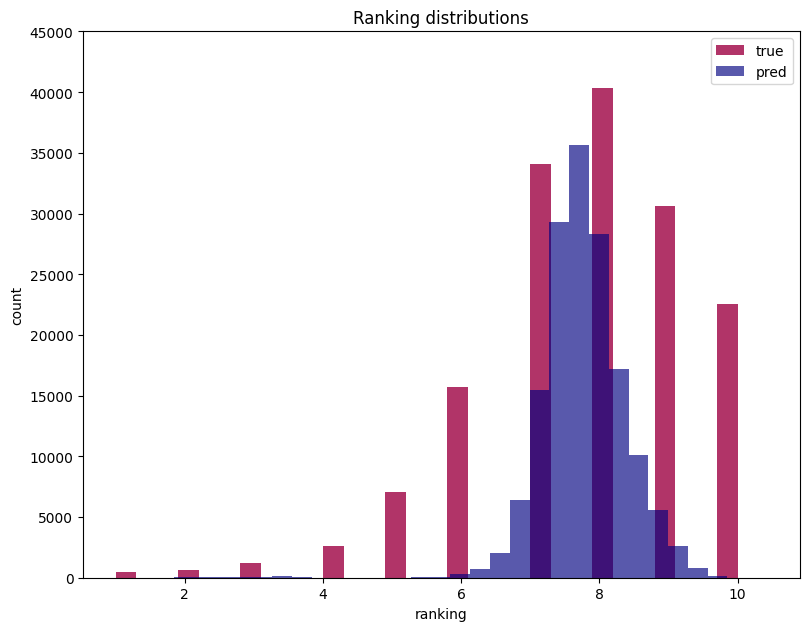

In [50]:
fig, ax = plt.subplots(figsize=(8,6))

num_color = 3
col = [plt.cm.Spectral(i/float(num_color-1)) for i in range(num_color)]

ax.hist(y_test, bins=30, facecolor=col[0], alpha=0.8, label='true')
ax.hist(y_pred, bins=30, facecolor='navy', alpha=0.65, label='pred')

fig.tight_layout()

plt.ylim(top=45000)

plt.title('Ranking distributions')
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend()

#if SAVE: plt.savefig('./figures/ranking_distributions_node2vec.jpg', bbox_inches = 'tight')
plt.show()